# Es mejor que cada una tenga su distribucion

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson

In [36]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [37]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [38]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [39]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

In [40]:
classes = df.iloc[:, -1].unique() # M
total = len(df)                   # N
attributes = df.columns           # X_i i \in {1, 2, ...}

Iwi = []        # Table of instances for each class
pwi = []        # a priori probability
pxjIwi = []     # p(X_j|w_i) for each class

for i in range(len(classes)):                   # For every class

    Iwi.append(df[df.iloc[:, -1] == classes[i]])         # Append the instances of the class
    pwi.append(len(Iwi[i])/total)               # Append the a priori probability
    
    pxjIwi.append([])                           # Append an empty list for the conditional probability - chat

    for attribute in attributes[:-1]:        # For every attribute except the last one (target variable)

        unique_values = Iwi[i][attribute].unique()

        # Bernoulli distribution
        if len(unique_values) == 2: 
            theta = Iwi[i][attribute].mean()    # Calculate the mean
            un_pxiIwi = bernoulli(theta)            # Create a Bernoulli distribution

        # Poisson distribution
        elif len(unique_values) < 10:
        # Test if the attribute is Poisson distributed
            mean = Iwi[i][attribute].mean()
            ks_test = kstest(Iwi[i][attribute], 'poisson', args=(mean,))
            if ks_test.pvalue > 0.05:
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

        # Multinomial distribution
            else:
                un_pxiIwi = Iwi[i][attribute].value_counts(normalize=True)  # Calculate the probability
                un_pxiIwi = multinomial(1, un_pxiIwi)                        # Create a Multinomial distribution 

        # Normal distribution
        else: 
            shapiro_test = shapiro(Iwi[i][attribute])
            if shapiro_test.pvalue > 0.05:
                xbar = Iwi[i][attribute].mean()
                s = Iwi[i][attribute].std()
                un_pxiIwi = norm(xbar, s)             # Create a Normal distribution

        # KDE distribution
            else:
                un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability

        pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

In [41]:
# print the distributions
for i in range(len(classes)):
    print("Class: ", classes[i])
    for j in range(len(attributes)-1):
        print("Attribute: ", attributes[j])
        print(pxjIwi[i][j])
        print()

Class:  0
Attribute:  Age

Attribute:  Sex

Attribute:  Chest Pain Type

Attribute:  Resting Blood Pressure

Attribute:  Cholesterol

Attribute:  Fasting Blood Sugar

Attribute:  Resting ECG

Attribute:  Max Heart Rate

Attribute:  Exercise Induced Angina

Attribute:  ST Depression

Attribute:  Slope

Attribute:  Number of Major Vessels

Attribute:  Thal

Class:  2
Attribute:  Age

Attribute:  Sex

Attribute:  Chest Pain Type

Attribute:  Resting Blood Pressure

Attribute:  Cholesterol

Attribute:  Fasting Blood Sugar

Attribute:  Resting ECG

Attribute:  Max Heart Rate

Attribute:  Exercise Induced Angina

Attribute:  ST Depression

Attribute:  Slope

Attribute:  Number of Major Vessels

Attribute:  Thal

Class:  1
Attribute:  Age

Attribute:  Sex

Attribute:  Chest Pain Type

Attribute:  Resting Blood Pressure

Attribute:  Cholesterol

Attribute:  Fasting Blood Sugar

Attribute:  Resting ECG

Attribute:  Max Heart Rate

Attribute:  Exercise Induced Angina

Attribute:  ST Depression



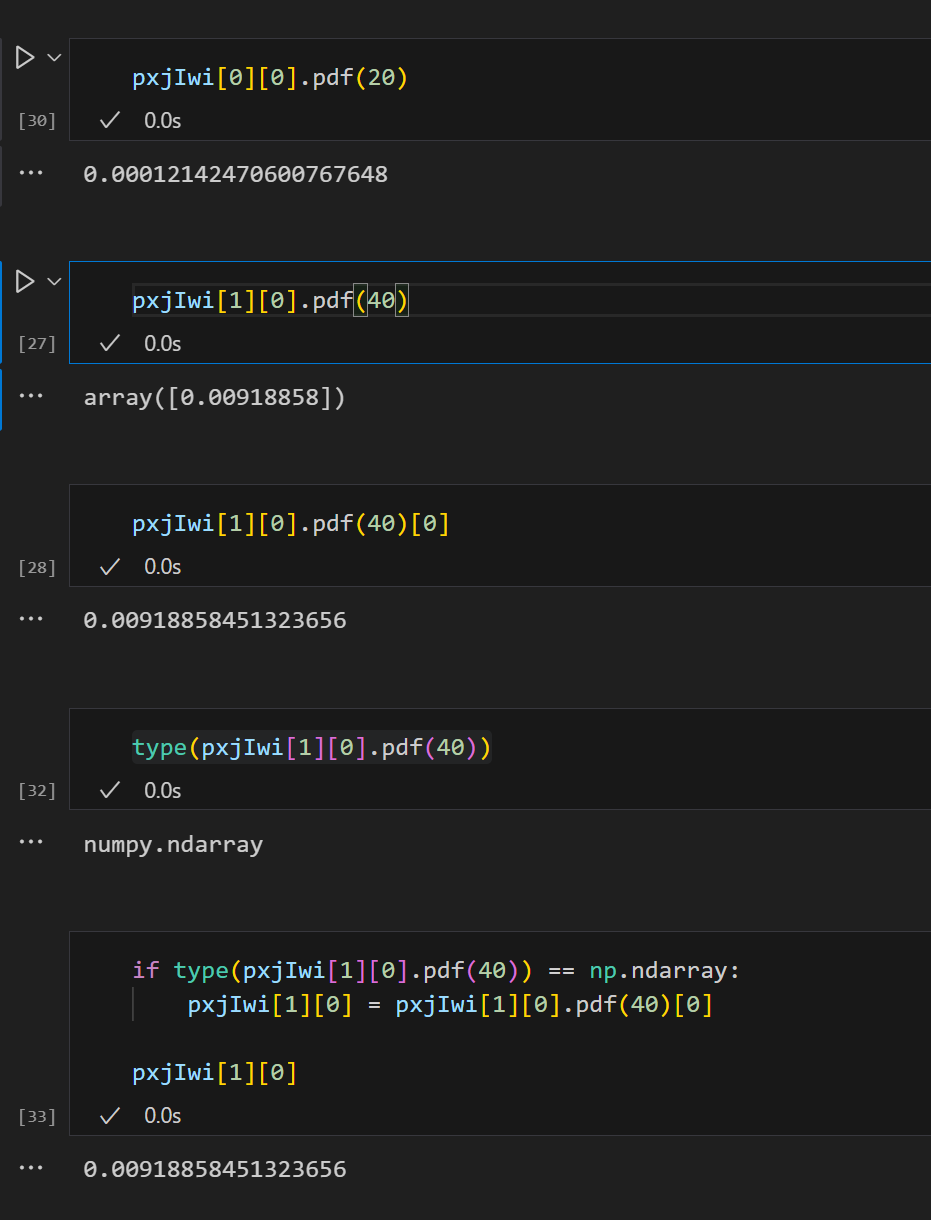

In [ ]:
def numtoarray(num, size):
    array = [0] * size
    array[num] = 1
    return array

def diagnostic(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
    
    thalarray = [0, 0, 0]
    if thal == 3:
        thalarray[0] = 1
    elif thal == 6:
        thalarray[1] = 1
    elif thal == 7:
        thalarray[2] = 1

    Pwis = []

    for clase in range(len(classes)):

        # Tienen que ir adentro porque los de la clase 3 no tienen Chest Pain Type 1
        cptarray = numtoarray(chest_pain_type - 1, Iwi[clase]["Chest Pain Type"].unique().size)
        recgarray = numtoarray(resting_ecg, Iwi[clase]["Resting ECG"].unique().size)
        slopearray = numtoarray(slope - 1, Iwi[clase]["Slope"].unique().size)
        nomvarray = numtoarray(number_of_major_vessels - 1, Iwi[clase]["Number of Major Vessels"].unique().size)
        
        Page = pxjIwi[clase][0].pdf(age)
        Psex = pxjIwi[clase][1].pmf(sex)
        Pcpt = pxjIwi[clase][2].pmf(cptarray)
        Prbp = pxjIwi[clase][3].pdf(resting_blood_pressure)
        Pcho = pxjIwi[clase][4].pdf(cholesterol)
        Pfbs = pxjIwi[clase][5].pmf(fasting_blood_sugar)
        Prec = pxjIwi[clase][6].pmf(recgarray)
        Pmhr = pxjIwi[clase][7].pdf(max_heart_rate)
        Peia = pxjIwi[clase][8].pmf(exercise_induced_angina)
        Pstd = pxjIwi[clase][9].pdf(st_depression)
        Pslo = pxjIwi[clase][10].pmf(slopearray)
        Pnmv = pxjIwi[clase][11].pmf(nomvarray)
        Ptal = pxjIwi[clase][12].pmf(thalarray)

        if type(Page) == np.ndarray:
            Page = Page[0]
            if np.isnan(Page):
                Page = 0

        if type(Psex) == np.ndarray:
            Psex = Psex[0]
            if np.isnan(Psex):
                Psex = 0

        if type(Pcpt) == np.ndarray:
            Pcpt = Pcpt[0]
            if np.isnan(Pcpt):
                Pcpt = 0

        if type(Prbp) == np.ndarray:
            Prbp = Prbp[0]
            if np.isnan(Prbp):
                Prbp = 0

        if type(Pcho) == np.ndarray:
            Pcho = Pcho[0]
            if np.isnan(Pcho):
                Pcho = 0
                
        if type(Pfbs) == np.ndarray:
            Pfbs = Pfbs[0]
        if type(Prec) == np.ndarray:
            Prec = Prec[0]
        if type(Pmhr) == np.ndarray:
            Pmhr = Pmhr[0]
        if type(Peia) == np.ndarray:
            Peia = Peia[0]
        if type(Pstd) == np.ndarray:
            Pstd = Pstd[0]
        if type(Pslo) == np.ndarray:
            Pslo = Pslo[0]
        if type(Pnmv) == np.ndarray:
            Pnmv = Pnmv[0]
        if type(Ptal) == np.ndarray:
            Ptal = Ptal[0]

        Pwi = pwi[clase] * Page * Psex * Pcpt * Prbp * Pcho * Pfbs * Prec * Pmhr * Peia * Pstd * Pslo * Pnmv * Ptal
        Pwis.append(Pwi)

        print(f"Diagnosis of heart disease {clase} is {Pwi}")

    argmax = np.argmax(Pwis)
    print(f"The most likely diagnosis is {argmax}")
    

diagnostic(20, 1, 1, 145, 233, 1, 1, 150, 0, 2.3, 3, 0, 6)

Diagnosis of heart disease 0 is 1.410633527989552e-17
Diagnosis of heart disease 1 is 8.977888184182789e-23
Diagnosis of heart disease 2 is nan
Diagnosis of heart disease 3 is 2.1893341451125408e-18
Diagnosis of heart disease 4 is 1.666388316223023e-18
The most likely diagnosis is 2


In [74]:
def numtoarray(num, size):
    array = [0] * size
    array[num] = 1
    return array

def diagnostic(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
    
    thalarray = [0, 0, 0]
    if thal == 3:
        thalarray[0] = 1
    elif thal == 6:
        thalarray[1] = 1
    elif thal == 7:
        thalarray[2] = 1

    Pwis = []

    for clase in range(len(classes)):

        # Tienen que ir adentro porque los de la clase 3 no tienen Chest Pain Type 1
        cptarray = numtoarray(chest_pain_type - 1, Iwi[clase]["Chest Pain Type"].unique().size)
        recgarray = numtoarray(resting_ecg, Iwi[clase]["Resting ECG"].unique().size)
        slopearray = numtoarray(slope - 1, Iwi[clase]["Slope"].unique().size)
        nomvarray = numtoarray(number_of_major_vessels - 1, Iwi[clase]["Number of Major Vessels"].unique().size)
        
        Page = pxjIwi[clase][0].pdf(age)
        Psex = pxjIwi[clase][1].pmf(sex)
        Pcpt = pxjIwi[clase][2].pmf(cptarray)
        Prbp = pxjIwi[clase][3].pdf(resting_blood_pressure)
        Pcho = pxjIwi[clase][4].pdf(cholesterol)
        Pfbs = pxjIwi[clase][5].pmf(fasting_blood_sugar)
        Prec = pxjIwi[clase][6].pmf(recgarray)
        Pmhr = pxjIwi[clase][7].pdf(max_heart_rate)
        Peia = pxjIwi[clase][8].pmf(exercise_induced_angina)
        Pstd = pxjIwi[clase][9].pdf(st_depression)
        Pslo = pxjIwi[clase][10].pmf(slopearray)
        Pnmv = pxjIwi[clase][11].pmf(nomvarray)
        Ptal = pxjIwi[clase][12].pmf(thalarray)

        listdep = [Page, Psex, Pcpt, Prbp, Pcho, Pfbs, Prec, Pmhr, Peia, Pstd, Pslo, Pnmv, Ptal]
        
        for i in range(len(listdep)):
            if type(listdep[i]) == np.ndarray:
                listdep[i] = listdep[i][0]
                if np.isnan(listdep[i]):
                    listdep[i] = 0

        product = 1
        for i in range(len(listdep)):
            product *= listdep[i]

        Pwi = pwi[clase] * product
        Pwis.append(Pwi)

        print(f"Diagnosis of heart disease {clase} is {Pwi}")

    argmax = np.argmax(Pwis)
    print(f"The most likely diagnosis is {argmax}")
    

diagnostic(20, 1, 1, 145, 233, 1, 1, 150, 0, 2.3, 3, 0, 6)

Diagnosis of heart disease 0 is 1.4106335279895522e-17
Diagnosis of heart disease 1 is 8.977888184182789e-23
Diagnosis of heart disease 2 is 0.0
Diagnosis of heart disease 3 is 2.1893341451125396e-18
Diagnosis of heart disease 4 is 1.6663883162230218e-18
The most likely diagnosis is 0


In [59]:
print(pxjIwi[2][0].pdf(20))
print(pxjIwi[2][1].pmf(1))
print(pxjIwi[2][2].pmf([0, 1, 0, 0]))
print(pxjIwi[2][3].pdf(145))
print(pxjIwi[2][4].pdf(233))
print(pxjIwi[2][5].pmf([0, 1, 0]))
print(pxjIwi[2][6].pmf([0, 1, 0]))
print(pxjIwi[2][7].pdf(150))
print(pxjIwi[2][8].pmf([0, 1, 0, 0]))
print(pxjIwi[2][9].pdf(2.3))
print(pxjIwi[2][10].pmf([0, 1, 0]))
print(pxjIwi[2][11].pmf([0, 1, 0, 0]))
print(pxjIwi[2][12].pmf([0, 1, 0]))

[4.21319631e-07]
0.8392857142857143
0.16071428571428573
[0.01493731]
0.008480112763134911
[0.94642857 0.05357143 0.94642857]
[nan nan nan]
0.01637261933194203
[0.53571429 0.46428571 0.53571429 0.53571429]
[0.17286025]
0.39285714285714285
0.3392857142857143
0.39285714285714285


In [63]:
pxjIwi[2][6].pmf([0, 1, 0])

array([nan, nan, nan])

In [71]:
pxjIwi[2][6].pmf([0, 1, 0])[0]

nan

In [70]:
## is the probability nan?
pxjIwi[2][6].pmf([0, 1, 0])[0] == np.nan

False

In [43]:
Iwi[0].head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0


In [44]:
diagnostic(20, 1, 1, 145, 233, 1, 1, 150, 0, 2.3, 3, 0, 6)

Diagnosis of heart disease 0 is 1.410633527989552e-17
Diagnosis of heart disease 1 is 8.977888184182789e-23
Diagnosis of heart disease 2 is nan
Diagnosis of heart disease 3 is 2.1893341451125408e-18
Diagnosis of heart disease 4 is 1.666388316223023e-18
[1.410633527989552e-17, 8.977888184182789e-23, nan, 2.1893341451125408e-18, 1.666388316223023e-18]
